# play_SignedDistance_EDContact
# modified from Hydroelastic Contact: Nonconvex Mesh
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact, study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

## Introduction

This tutorial shows you how to set up simulations using compliant-hydroelastic nonconvex meshes. We'll use a simple example of a bell pepper dropped onto a bowl on a table top, with all three objects represented by compliant-hydroelastic meshes. Contact forces are calculated and visualized.

In [1]:
import os
from pathlib import Path

from IPython.display import Code

from pydrake.geometry import StartMeshcat, Rgba, ConvertVolumeToSurfaceMesh
from pydrake.math import RigidTransform
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ApplyVisualizationConfig, ModelVisualizer, VisualizationConfig

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Create compliant-hydroelastic bell pepper in SDFormat

*Make sure you have the MeshCat tab opened in your browser; the link is shown immediately above.*

We will load a compliant-hydroelastic bell pepper from an SDFormat file. We will show the file for you to read, and then use `ModelVisualizer` to display it.

The file specifies inertia in the `<inertial>` block. See [mesh_to_model](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html) to compute the inertia matrix.

The file specifies visual geometry using a triangle surface mesh and a collision geometry using a tetrahedral volume mesh from a VTK file.

The file's `<drake:proximity_properties>` stanza will control hydroelastic contacts. Look in particular at the `<drake:hydroelastic_modulus>`.

In the MeshCat tab, you should toggle the "proximity" checkbox to show the collision geometry, which is the tetrahedral mesh that fits the visual geometry's triangle mesh.  See the section *Viewing models* in [authoring_multibody_simulation.ipynb](./authoring_multibody_simulation.ipynb) for more details.

In [3]:
# Show the contents of the SDFormat file.
bell_pepper_url = "package://drake_models/veggies/yellow_bell_pepper_no_stem_low.sdf"
bell_pepper_str = Path(PackageMap().ResolveUrl(bell_pepper_url)).read_text(encoding="utf-8")
Code(bell_pepper_str, language="xml")

<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="drake.mit.edu">
  <model name="yellow_bell_pepper_no_stem">
    <link name="yellow_bell_pepper_no_stem">
      <inertial>
        <pose>0.000537 -0.00272 0.0384 0 0 0</pose>
        <mass>0.159</mass>
        <inertia>
          <ixx> 0.000101</ixx>
          <ixy>-0.000001</ixy>
          <ixz>-0.000004</ixz>
          <iyy> 0.000105</iyy>
          <iyz> 0.000007</iyz>
          <izz> 0.000107</izz>
        </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>package://drake_models/veggies/assets/yellow_bell_pepper_no_stem_low.gltf</uri>
            <scale>1 1 1</scale>
          </mesh>
        </geometry>
      </visual>
      <collision name="collision">
        <geometry>
          <mesh>
            <uri>package://drake_models/veggies/assets/yellow_bell_pepper_no_stem_low.vtk</uri>
            <scale>1 1 1</scale>
          </mesh>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>5.0e4</drake:hydroelastic_modulus>
          <!-- Most shapes (capsule, cylinder, ellipsoid, sphere) need
            drake:mesh_resolution_hint, but the resolution hint is no-op
            for the mesh geometry. That's why we do not set it here. -->
          <drake:hunt_crossley_dissipation>10</drake:hunt_crossley_dissipation>
          <!-- Both mu_dynamic and mu_static are used in Continuous system.
            Only mu_dynamic is used in Discrete system.  -->
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:mu_static>1.0</drake:mu_static>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="origin">
      <pose relative_to="yellow_bell_pepper_no_stem">0 0 0 0 0 0</pose>
    </frame>
    <frame name="flush_bottom_center__z_up">
      <pose relative_to="yellow_bell_pepper_no_stem">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>

In [4]:
# Visualize the SDFormat file you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.AddModels(url=bell_pepper_url)
visualizer.Run(loop_once=True)

## Create compliant-hydroelastic bowl in URDF

We will load a compliant-hydroelastic bowl with URDF file. We will show the file for you to read, and then use `ModelVisualizer` to display it.

The file specifies inertia in the `<inertial>` block. See [mesh_to_model](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html) to compute the inertia matrix.

The file specifies visual geometry using a triangle surface mesh and a collision geometry using a tetrahedral volume mesh from a VTK file.

In the `<drake:proximity_properties>` block, the `<drake:hydroelastic_modulus>` is set to 1e7 Pascals, so the bowl is stiffer than the bell pepper.

In [5]:
# Show the contents of the URDF file.
bowl_url = "package://drake_models/dishes/evo_bowl_compliant.urdf"
bowl_str = Path(PackageMap().ResolveUrl(bowl_url)).read_text(encoding="utf-8")
Code(bowl_str, language="xml")

<?xml version="1.0"?>
<robot xmlns:drake="http://drake.mit.edu" name="bowl">
  <link name="bowl">
    <inertial>
      <mass value="0.5"/>
      <origin xyz="-6.8577139059790044e-06 -1.7473168538940867e-05 -0.003065665933405878"/>
      <inertia ixx="0.0009715521141455593"
               ixy="-1.8443983471817828e-07"
               ixz="2.4082416205698527e-08"
               iyy="0.0009793965751030533"
               iyz="6.72877272895659e-08"
               izz="0.001592061359500251"/>
    </inertial>
    <visual name="visual">
      <geometry>
        <mesh filename="package://drake_models/dishes/assets/evo_bowl.gltf"/>
      </geometry>
    </visual>
    <collision name="collision">
      <geometry>
        <mesh filename="package://drake_models/dishes/assets/evo_bowl_fine44k.vtk"/>
      </geometry>
      <drake:proximity_properties>
        <drake:compliant_hydroelastic/>
        <drake:hydroelastic_modulus value="1e7"/>
        <drake:mu_dynamic value="0.5"/>
        <drake:hunt_crossley_dissipation value="1.25"/>
      </drake:proximity_properties>
    </collision>
  </link>
</robot>

### Deactivate test mode

In [6]:
# (Drake users can ignore this cell. When Drake regression testing runs in CI,
# we need to use a coarser tetrahedral mesh to improve debug performance.)
test_mode = False

In [7]:
if test_mode:
    bowl_str = bowl_str.replace("evo_bowl_fine44k.vtk", 
                                "evo_bowl_coarse3k.vtk")

In [8]:
# Visualize the URDF file.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModels(file_contents=bowl_str, file_type="urdf")
visualizer.Run(loop_once=True)

## Create compliant-hydroelastic table top in URDF

The following URDF file specifies a compliant-hydroelastic box for a table top.  We demonstrate how to set relevant hydroelastic properties in URDF; however, Drake prefers SDFormat to URDF.

Both the `<visual>` and `<collision>` geometries are boxes of the same size.

In the `<drake:proximity_properties>` block, we will set `<drake:hydroelastic_modulus>` to 1e7 Pascals.

We do not specify the inertia matrix of the table top because, in the next section when we set up `Diagram`, we will fix the table top to the world frame. It will not move.

In [9]:
# Show the contents of the URDF file.
table_top_url = "package://drake_models/dishes/table_top.urdf"
table_top_str = Path(PackageMap().ResolveUrl(table_top_url)).read_text(encoding="utf-8")
Code(table_top_str, language="xml")

<?xml version="1.0"?>
<robot name="table_top" xmlns:drake="http://drake.mit.edu">
  <link name="table_top_link">
    <visual name="visual">
      <geometry>
        <box size="0.6 1.0 0.05"/>
      </geometry>
      <material>
       <color rgba="0.9 0.8 0.7 0.5"/>
      </material>
    </visual>
    <collision name="collision">
      <geometry>
        <box size="0.6 1.0 0.05"/>
      </geometry>
      <drake:proximity_properties>
        <drake:compliant_hydroelastic/>
        <drake:hydroelastic_modulus value="1e7"/>
        <drake:mu_dynamic value="0.5"/>
        <drake:hunt_crossley_dissipation value="1.25"/>
      </drake:proximity_properties>
    </collision>
  </link>
  <frame name="top_surface" link="table_top_link" xyz="0 0 0.025" rpy="0 0 0"/>
</robot>

In [10]:
# Visualize the URDF file.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.AddModels(url=table_top_url)
visualizer.Run(loop_once=True)

## Create Diagram of the scene

The function `add_scene()` below will create a scene using the assets that we created. It will use `Parser` to add the URDF and SDFormat strings into the scene. After this step, the next section will add visualization.

In [11]:
def add_scene(time_step):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_approximation="lagged"),
        builder)
    parser = Parser(plant)

    # Load the assets that we created.
    parser.AddModels(url=bell_pepper_url)
    parser.AddModels(file_contents=bowl_str, file_type="urdf")
    parser.AddModels(url=table_top_url)

    # Weld the table top to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Place the bowl on top of the table.
    X_WB = RigidTransform(p=[0, 0, 0.03])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("bowl"), X_WB)
    
    # Drop the bell pepper from above the rim of the bowl. 
    X_WC = RigidTransform(p=[-0.06, 0, 0.30])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("yellow_bell_pepper_no_stem"), X_WC)

    return builder, plant

## Set up visualization

The function `add_viz()` below will create visualization. First we will call `ApplyVisualizationConfig()` to visualize our assets. At this step we will set `publish_contacts=False`, so we can customize contact visualization afterwards. 

To visualize contact result, we will add `ContactVisualizer` with `newtons_per_meter= 20` and `newtons_meters_per_meter= 0.1`. It will draw a red arrow of length 1 meter for each force of 20 newtons and a blue arrow of length 1 meter for each torque of 0.1 newton\*meters. The next section will run the simulation.

In [12]:
def add_viz(builder, plant):
    ApplyVisualizationConfig(
        builder=builder, meshcat=meshcat,
        config=VisualizationConfig(
                 default_proximity_color=Rgba(r=0.8, g=0, b=0, a=0.5),
                 publish_contacts=False))    
    ContactVisualizer.AddToBuilder(
        builder=builder, plant=plant, meshcat=meshcat,
        params=ContactVisualizerParams(
                 newtons_per_meter=20,
                 newton_meters_per_meter= 0.1))

## Run simulation

We will run the simulation. In MeshCat, the red arrow will represent the force `f`, and the blue arrow will represent the torque `tau`. You should see the contact patch moving around together with the force and torque vectors.

After running the code below, playback with `timeScale` = 0.1 to appreciate the contact dynamics. You should see the force and torque vectors oscillate synchronously with the rocking bell pepper and bowl. See the section *Playback recording of the simulation* in [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb) for more details.

Currently playing back the simulation will show contact force and torque correctly; however, it does not show contact patch appropriately, which could be confusing. Issue [19142](https://github.com/RobotLocomotion/drake/issues/19142) explains the problem in more details.

In [13]:
# Clear MeshCat window from the previous blocks.
meshcat.Delete()
meshcat.DeleteAddedControls()

time_step = 1e-2
builder, plant = add_scene(time_step)
add_viz(builder, plant)

diagram = builder.Build()

simulator = Simulator(diagram)

# In interactive mode, simulate for longer time.
# In test mode, simulate for shorter time.
sim_time = 2 if not test_mode else 0.01

meshcat.StartRecording()
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(sim_time)
meshcat.StopRecording()
meshcat.PublishRecording()

### Temporary section to test ComputeSignedDistanceToPoint() with meshes

In [14]:
meshcat.Delete("signed_distances")

scene_graph = diagram.GetSubsystemByName("scene_graph")
inspector = scene_graph.model_inspector()
query_object = scene_graph.get_query_output_port().Eval(
    scene_graph.GetMyContextFromRoot(simulator.get_context()))
# The query point is near the centroid of the bell pepper.
# The signed distances should be around -2 cm inside the bell pepper,
# +3.8 cm outside the bowl, and +4.4 cm above the table top.
p_WQ = [-0.016, -0.012, 0.044]
signed_distances = query_object.ComputeSignedDistanceToPoint(p_WQ)

def DrawSignedDistanceData(p_WQ, d):
  geometry_id = d.id_G
  geometry_name = inspector.GetName(geometry_id)
  grad_W = d.grad_W  
  p_GN = d.p_GN  
  X_WG = query_object.GetPoseInWorld(geometry_id)
  p_WN = X_WG.multiply(p_GN)
  color = Rgba(r=1, g=0, b=0, a=1)
  if d.distance < 0:
    color = Rgba(r=0, g=0, b=1, a=1)    
  # Draw a line between the query point and its nearest point.  
  meshcat.SetLine(path=f"signed_distances/{geometry_name}/nearest/to_p_WQ_{p_WQ}",
        vertices=np.array([p_WQ, p_WN]).T,
        line_width=2.0, rgba=color)
  # Draw a 1-cm line from the query point in the gradient direction.
  meshcat.SetLine(path=f"signed_distances/{geometry_name}/grad_W/to_p_WQ_{p_WQ}",
        vertices=np.array([p_WQ, p_WQ + 0.01 * grad_W]).T,
        line_width=4.0, rgba=Rgba(r=0.7, g=0.7, b=0.7, a=1)) 

import numpy as np
for d in signed_distances:
  geometry_id = d.id_G  
  geometry_name = inspector.GetName(geometry_id)
  grad_W = d.grad_W  
  p_GN = d.p_GN  
  print(f"{geometry_name}")
  print(f"distance = {d.distance}")
  print(f"grad_W = {grad_W}")
  print(f"p_GN = {p_GN}")
  print(f"id_G = {geometry_id}")
  print()
  DrawSignedDistanceData(p_WQ, d)
    

yellow_bell_pepper_no_stem::collision
distance = -0.019035759642582112
grad_W = [ 0.45219105  0.8680317  -0.20504689]
p_GN = [0.00489239 0.00898376 0.05558989]
id_G = <GeometryId value=189>

bowl::collision
distance = 0.03751857725749626
grad_W = [-0.0239018  -0.02021671  0.99950987]
p_GN = [-0.01626713 -0.01140548 -0.02405013]
id_G = <GeometryId value=196>

table_top::collision
distance = 0.044
grad_W = [0. 0. 1.]
p_GN = [-0.016 -0.012  0.025]
id_G = <GeometryId value=203>



## Temporary section: Query points on a grid

In [15]:
meshcat.Delete("signed_distances")

def DrawToNearestPoint(p_WQ, d):
  geometry_id = d.id_G
  geometry_name = inspector.GetName(geometry_id)
  grad_W = d.grad_W  
  p_GN = d.p_GN  
  X_WG = query_object.GetPoseInWorld(geometry_id)
  p_WN = X_WG.multiply(p_GN)
  color = Rgba(r=1, g=0, b=0, a=1)
  if d.distance < 0:
    color = Rgba(r=0, g=0, b=1, a=1)    
  # Draw a line between the query point and its nearest point.  
  meshcat.SetLine(path=f"signed_distances/{geometry_name}/nearest/to_p_WQ_{p_WQ}",
        vertices=np.array([p_WQ, p_WN]).T,
        line_width=2.0, rgba=color)

# 5 x 5 x 5 Grid of [-0.05, 0.05]x[-0.05, 0.05]x[-0.05, 0.05] meters
import numpy as np
for x in np.linspace(-0.05, 0.05, 5):
  for y in np.linspace(-0.05, 0.05, 5):
    for z in np.linspace(-0.05, 0.05, 5):
      p_WQ = [x, y, z]
      signed_distances = query_object.ComputeSignedDistanceToPoint(p_WQ)
      for d in signed_distances:
          DrawToNearestPoint(p_WQ, d)

print("Done")            

Done


## Query points near medial surfaces between objects

In [16]:
meshcat.Delete("signed_distances")

def DrawSignedDistanceDataIfNearMidSurface(p_WQ, d0, d1, d2):
    if abs(d0.distance - d1.distance) < 0.001 and \
       abs(d0.distance) < abs(d2.distance) and \
       abs(d1.distance) < abs(d2.distance) :        
      DrawToNearestPoint(p_WQ, d0)
      DrawToNearestPoint(p_WQ, d1)
    

# 15 x 15 x 15 Grid of [-0.10, 0.10]x[-0.10, 0.10]x[-0.10, 0.10] meters
import numpy as np
for x in np.linspace(-0.10, 0.10, 15):
  for y in np.linspace(-0.10, 0.10, 15):
    for z in np.linspace(-0.10, 0.10, 15):
      p_WQ = [x, y, z]
      signed_distances = query_object.ComputeSignedDistanceToPoint(p_WQ)
      d0 = signed_distances[0]
      d1 = signed_distances[1]
      d2 = signed_distances[2]
    
      DrawSignedDistanceDataIfNearMidSurface(p_WQ, d0, d1, d2)
      DrawSignedDistanceDataIfNearMidSurface(p_WQ, d1, d2, d0)
      DrawSignedDistanceDataIfNearMidSurface(p_WQ, d2, d0, d1)
        
      
print("Done")

Done


### Query Bowl's SDF on Bell Pepper's surface

In [17]:
%%time

meshcat.Delete("signed_distances")

all_ids = inspector.GetAllGeometryIds()
for id in all_ids:
  if inspector.GetName(id) == "yellow_bell_pepper_no_stem::collision" :
    pepper_id = id
  if inspector.GetName(id) == "bowl::collision" :
    bowl_id = id

print(pepper_id)
print(bowl_id)

pepper_tri_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(pepper_id))
print(f"pepper_tri_mesh.num_vertices() = {pepper_tri_mesh.num_vertices()}")

bowl_tri_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(bowl_id))
print(f"bowl_tri_mesh.num_vertices() = {bowl_tri_mesh.num_vertices()}")


# Signed distances at pepper points from bowl mesh
# P is the local frame of the pepper
X_WP = query_object.GetPoseInWorld(pepper_id)
for p_PQ in pepper_tri_mesh.vertices() :
  p_WQ = X_WP.multiply(p_PQ)
  signed_distances = query_object.ComputeSignedDistanceToPoint(p_WQ)
  for d in signed_distances:
    if d.id_G == bowl_id:
      DrawToNearestPoint(p_WQ, d)
    
print("Done")

<GeometryId value=189>
<GeometryId value=196>
pepper_tri_mesh.num_vertices() = 486
bowl_tri_mesh.num_vertices() = 3957
Done
CPU times: user 289 ms, sys: 50.6 ms, total: 339 ms
Wall time: 297 ms


### Paint Bowl's SDF values on Bell Pepper's surface

In [18]:
%%time

meshcat.Delete("signed_distances")

all_ids = inspector.GetAllGeometryIds()
for id in all_ids:
  if inspector.GetName(id) == "yellow_bell_pepper_no_stem::collision" :
    pepper_id = id
  if inspector.GetName(id) == "bowl::collision" :
    bowl_id = id

pepper_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(pepper_id))
print(f"pepper_mesh.num_vertices() = {pepper_mesh.num_vertices()}")

bowl_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(bowl_id))
print(f"bowl_mesh.num_vertices() = {bowl_mesh.num_vertices()}")

# Signed distances at pepper points from bowl mesh
# P is the local frame of the pepper
X_WP = query_object.GetPoseInWorld(pepper_id)

vertex_list = [X_WP.multiply(p_PQ)
               for p_PQ in pepper_mesh.vertices()]
vertices = np.array(vertex_list).transpose()

triangle_list = [np.array([tri.vertex(0), tri.vertex(1), tri.vertex(2)])
                 for tri in pepper_mesh.triangles()]
triangles = np.array(triangle_list).transpose()

def DistanceColor(distance_value):  
  if distance_value > 0:
    color = np.array([1000 * distance_value, 0.2, 0.2])
  else:  
    color = np.array([0.2, 0.2, -distance_value * 10000])
  return color

def SignedDistanceColor(signed_distances):
  for d in signed_distances:
    if d.id_G == bowl_id:
        return DistanceColor(d.distance)    
  return np.zeros([3,1])

signed_distances_list = [query_object.ComputeSignedDistanceToPoint(p_WQ)
                         for p_WQ in vertex_list]
color_list = [SignedDistanceColor(sd)
              for sd in signed_distances_list]
colors = np.array(color_list).transpose()
    
    
meshcat.Delete("BellPepper_with_BowlSDF")
meshcat.SetTriangleColorMesh("BellPepper_with_BowlSDF/shade",
                         vertices, triangles, colors, wireframe=False)
meshcat.SetTriangleColorMesh("BellPepper_with_BowlSDF/wireframe",
                         vertices, triangles, colors, wireframe=True)
    
print("Done")

pepper_mesh.num_vertices() = 486
bowl_mesh.num_vertices() = 3957
Done
CPU times: user 158 ms, sys: 7.95 ms, total: 166 ms
Wall time: 158 ms


### Captured Images

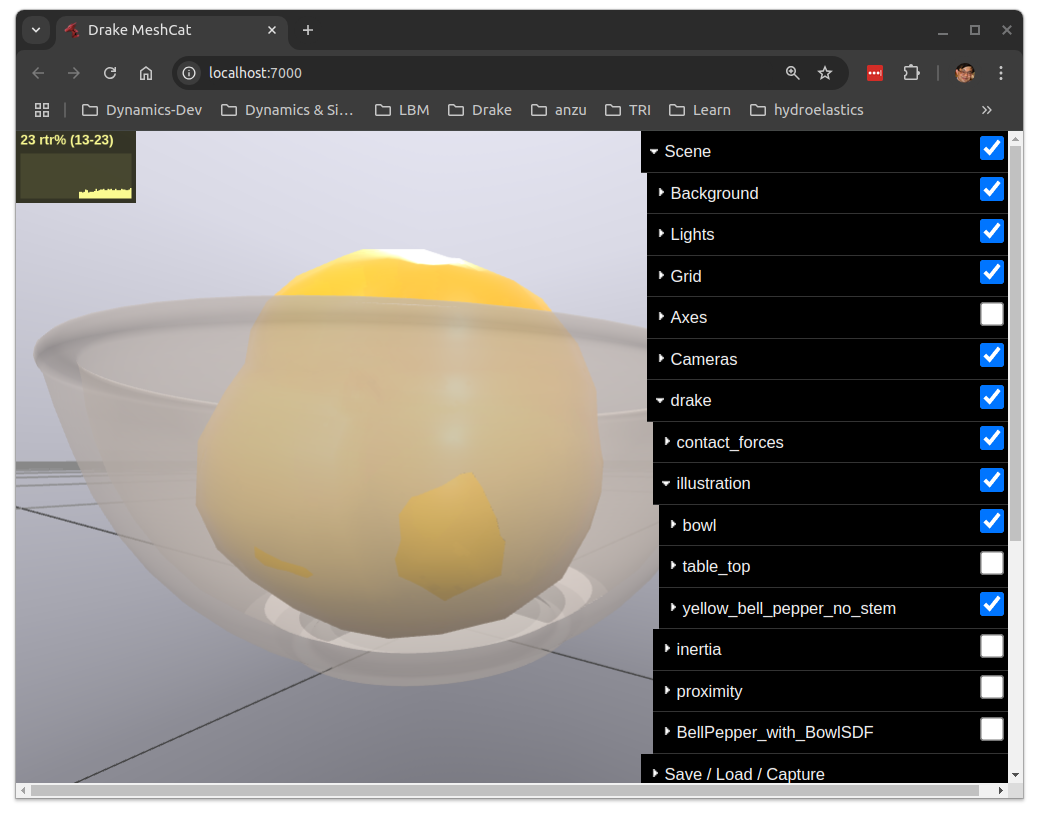

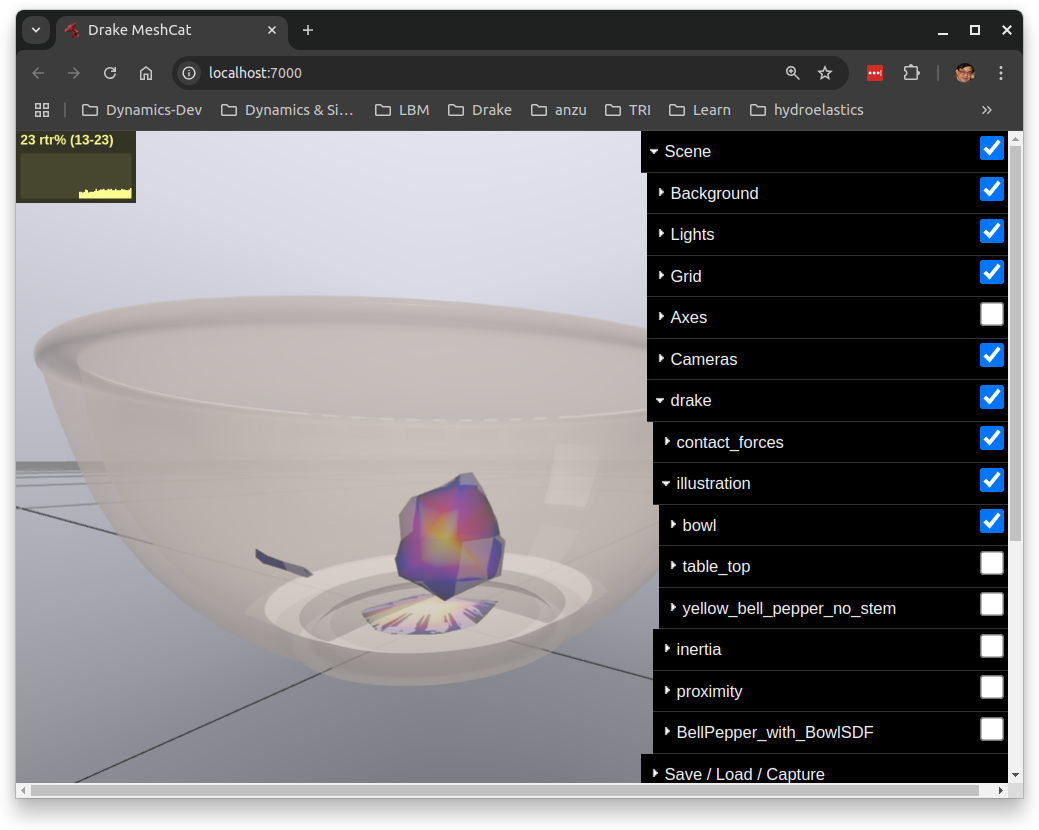

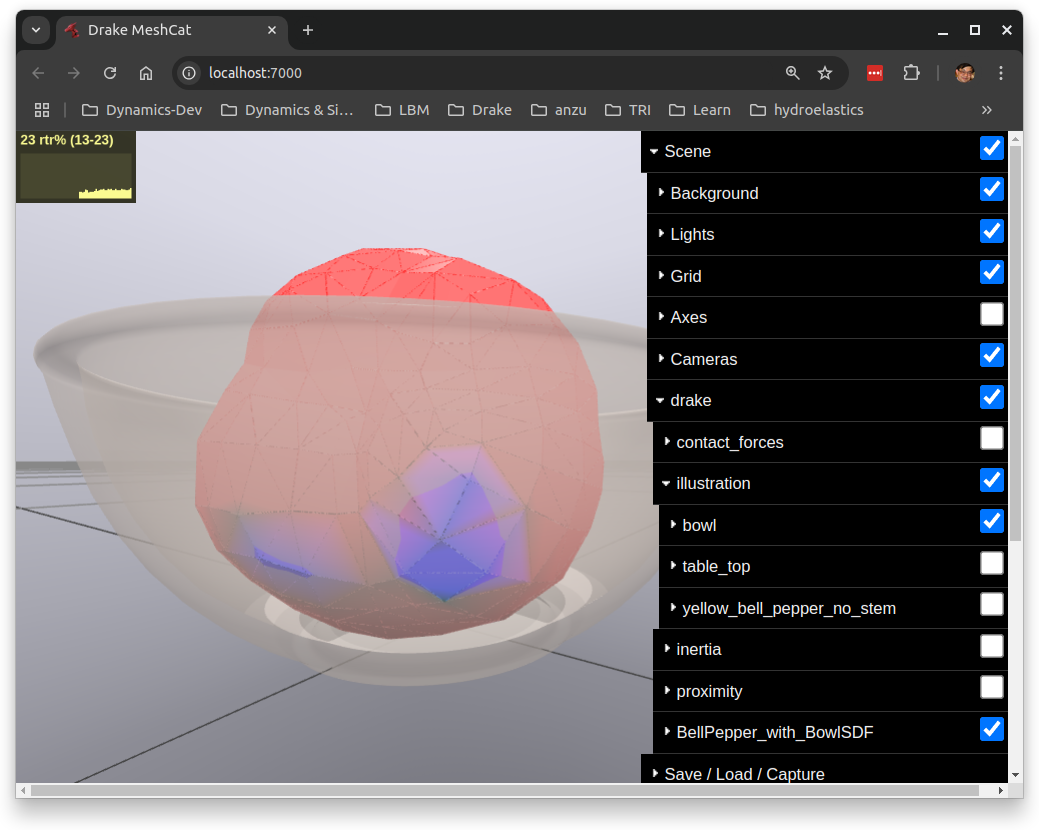

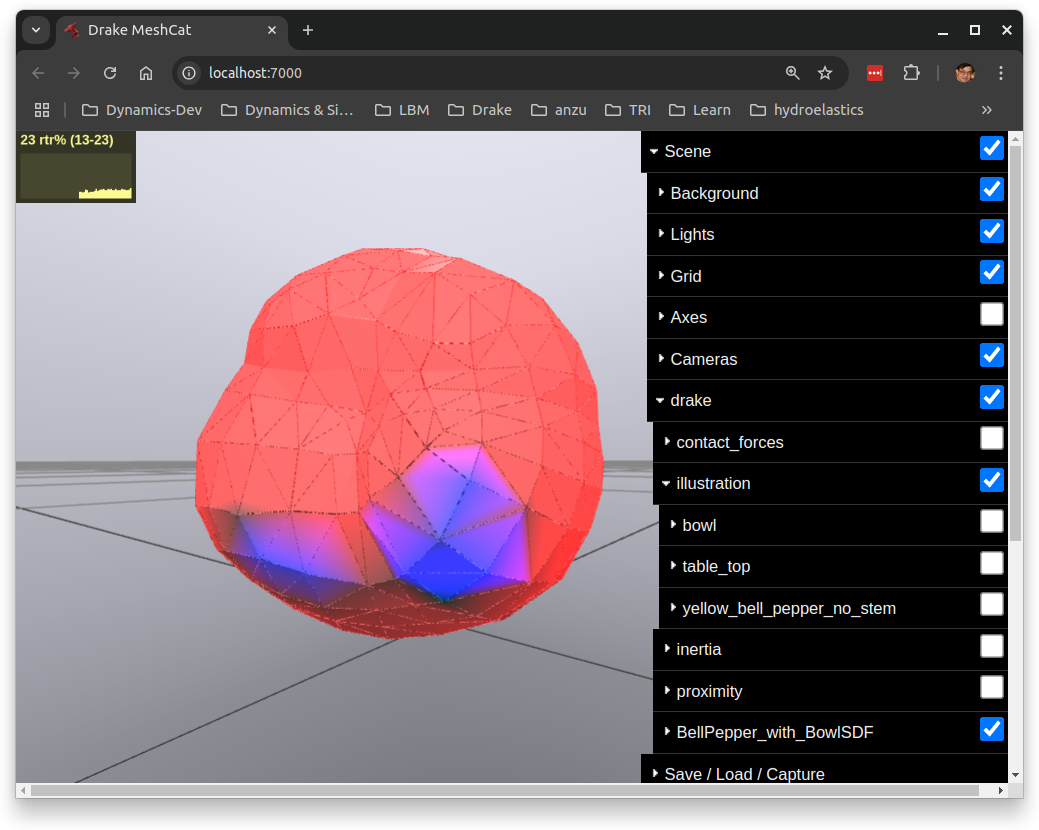

## Download simulation result into a html file for sharing

You can download the simulation result into a self-contained html file, allowing others to playback the simulated results without simulating. The following code prints the URL for downloading. Click on the printed URL to download.

In [19]:
print(f"{meshcat.web_url()}/download")

http://localhost:7000/download


## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). A pressure field model for fast, robust approximation of net contact force and moment between nominally rigid objects. In 2019 IEEE/RSJ International Conference on Intelligent Robots and Systems(IROS) (pp. 8238-8245). IEEE. [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022). Velocity Level Approximation of Pressure Field Contact Patches. IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600. [link](https://arxiv.org/abs/2110.04157v2)

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University. [link](https://ecommons.cornell.edu/handle/1813/112919)